In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

sns.set_style('whitegrid')
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [17]:
# Dataset Load

train = pd.read_csv('./data/gender_train.csv')
test = pd.read_csv('./data/gender_test.csv')

submit = pd.DataFrame(test['PassengerId'])

## Data Manupulation

In [19]:
# Label Encoder

train['Sex'].replace({'male': 0, 'female': 1}, inplace=True)
train['Embarked'].replace({'S':1, 'C':2, 'Q':3}, inplace=True)

In [20]:
# Deriving title from name columns

train['title'] = 0
for i in range(0, len(train)):
    train.loc[i, 'title'] = train['Name'].iloc[i].split(',')[1].split('.')[0][1:]
train['title'].replace({'Mr': 1, 'Miss': 2, 'Mrs': 2, 'Master': 3, 'Dr': 4, 'Rev': 5}, inplace=True)
train['title'].replace(['Major', 'Mlle', 'Col', 'Don', 'the Countess', 'Sir', 'Capt', 'Mme', 'Lady', 'Jonkheer', 'Ms'], 6, inplace=True)

In [21]:
# Defining a columns representing family group
train['family'] = train['SibSp'] + train['Parch'] + 1
def family(size):
    a = ''
    if(size<=1):
        a = 1 # Alone
    elif(size<=2):
        a = 2 # Couple
    elif(size<=4):
        a = 3 # small family
    elif(size<=6):
        a = 4 # medium family
    else:
        a = 5 # large family
    return a
train['family'] = train['family'].map(family)

In [22]:
# Extracting Cabin name
for i in range(len(train)):
    if not(pd.isnull(train['Cabin'].iloc[i])):
        train.loc[i, 'Cabin'] = train['Cabin'].loc[i][0]
train['Cabin'].replace({'C': 1, 'B': 2, 'D': 3, 'E': 4, 'A': 5, 'F': 6, 'G': 7, 'T': 8}, inplace=True)
train['Fare'] = np.sqrt(train['Fare'])

In [23]:
# Drop unnecessary columns
train.drop(['Name', 'SibSp', 'Parch', 'Ticket', 'PassengerId', 'Cabin'], axis=1, inplace=True)

## Data Visualization

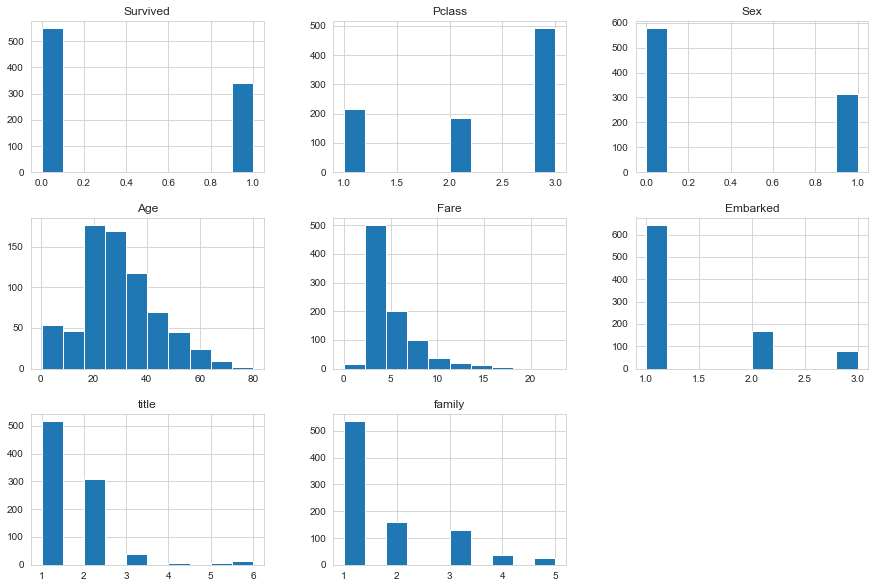

In [24]:
# Histogram
train.hist(figsize=(15,10))
plt.show()

<AxesSubplot:>

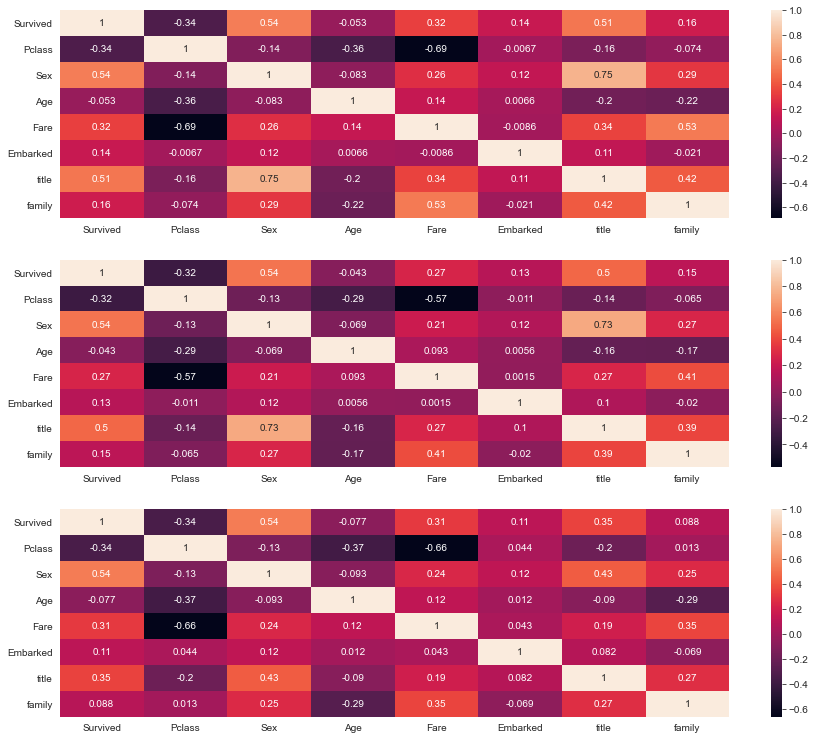

In [25]:
# Correlation

fig, ax = plt.subplots(3, 1, figsize=(15, 13))
sns.heatmap(train.corr('spearman'), annot=True, ax=ax[0], label='spearman')
sns.heatmap(train.corr('kendall'), annot=True, ax=ax[1], label='kendall')
sns.heatmap(train.corr('pearson'), annot=True, ax=ax[2], label='pearson')

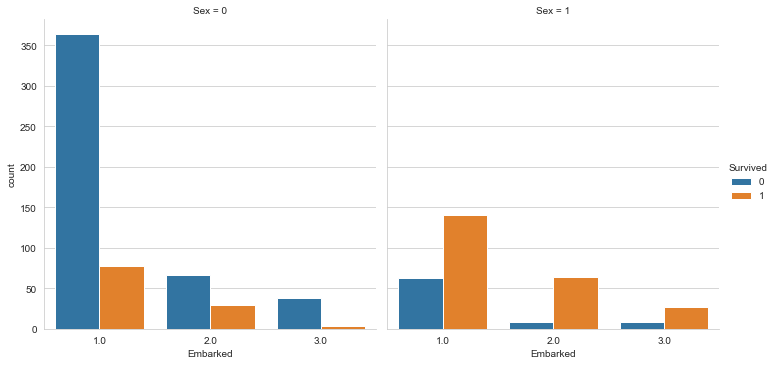

In [26]:
# Embarked

sns.catplot(x='Embarked', data=train, kind='count', hue='Survived', col='Sex')

<AxesSubplot:xlabel='family', ylabel='count'>

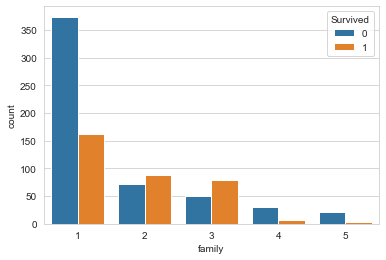

In [28]:
sns.countplot(x='family', data=train, hue='Survived')

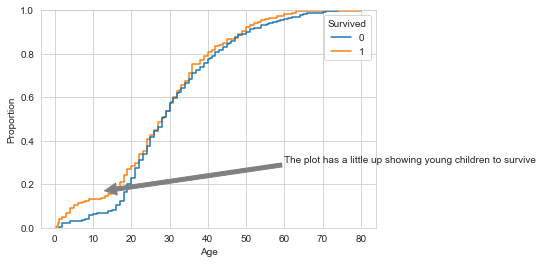

In [29]:
sns.ecdfplot(x='Age', data=train, hue='Survived')
plt.annotate('The plot has a little up showing young children to survive', xy=(13, 0.17), xytext=(60, 0.3), arrowprops=({'color': 'gray'}))
plt.show()

In [30]:
train = pd.get_dummies(train, columns=['Pclass', 'Embarked', 'title', 'family'], drop_first=True)

impute = KNNImputer(n_neighbors=13)
train = pd.DataFrame(impute.fit_transform(train), columns=train.columns)

## Model Selection

In [31]:
model = []
model.append(('Logistic Regression', LogisticRegression(max_iter=1000)))
model.append(('LDA', LinearDiscriminantAnalysis()))
model.append(('SVC', SVC(kernel='rbf')))
model.append(('DTC', DecisionTreeClassifier()))
model.append(('GBC', GradientBoostingClassifier()))
model.append(('RFC', RandomForestClassifier()))
model.append(('Kneig', KNeighborsClassifier()))

X = train.drop('Survived', axis=1)
y = train['Survived']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

In [32]:
scores = []

for name, models in model:
    pipeline = Pipeline(steps=[('scale', MinMaxScaler()), ('model', models)])
    cv = StratifiedKFold(n_splits=10, random_state=21, shuffle=True)
    score = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    scores.append((name, np.mean(score)))

scores

[('Logistic Regression', 0.8272159800249688),
 ('LDA', 0.82832709113608),
 ('SVC', 0.8238077403245943),
 ('DTC', 0.7834332084893882),
 ('GBC', 0.8350187265917602),
 ('RFC', 0.8204744069912608),
 ('Kneig', 0.8159300873907617)]

In [33]:
# Classfication report

from sklearn.metrics import classification_report

model = LogisticRegression(max_iter=3000)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.90      0.89       168
         1.0       0.83      0.78      0.80       100

    accuracy                           0.86       268
   macro avg       0.85      0.84      0.85       268
weighted avg       0.86      0.86      0.86       268



In [34]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.89      0.87       168
         1.0       0.80      0.76      0.78       100

    accuracy                           0.84       268
   macro avg       0.83      0.82      0.83       268
weighted avg       0.84      0.84      0.84       268



## Model classification using voting classifier

In [35]:
estimator = []
estimator.append(('LR', GradientBoostingClassifier()))
estimator.append(('SVC', RandomForestClassifier()))
estimator.append(('kd', LogisticRegression(max_iter=3000)))

# Voting Classifier with hard voting
vot_hard = VotingClassifier(estimators=estimator, voting='hard')
vot_hard.fit(X_train, y_train)
y_pred = vot_hard.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.89      0.88       168
         1.0       0.81      0.78      0.80       100

    accuracy                           0.85       268
   macro avg       0.84      0.84      0.84       268
weighted avg       0.85      0.85      0.85       268



In [36]:
pipeline = Pipeline(steps=[('scale', RobustScaler()), ('jj', SelectKBest(score_func=mutual_info_classif, k=13)),
 ('model', VotingClassifier(estimators= estimator, voting='hard'))])
cv = StratifiedKFold(n_splits=10, random_state=21, shuffle=True)
pipeline.fit(X, y)
y_pred = pipeline.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95       168
         1.0       0.95      0.87      0.91       100

    accuracy                           0.93       268
   macro avg       0.94      0.92      0.93       268
weighted avg       0.93      0.93      0.93       268



## Hyperparameter tuning

In [38]:
# KNeighborsClassifier

from sklearn.model_selection import GridSearchCV

metrics = ['euclidean', 'manhattan']
neighbors = np.arange(1, 16)
param_grid = dict(metric=metrics, n_neighbors=neighbors)
knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', refit=True)
grid_search.fit(X, y)
print(grid_search.best_params_)

{'metric': 'manhattan', 'n_neighbors': 4}


In [41]:
# Random Forest Classifier

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

param_dist = {'max_depth': [3, None],
              'max_features': sp_randint(1, X.shape[1]),
              'min_samples_split': sp_randint(2, 11),
              'bootstrap': [True, False],
              'n_estimators': sp_randint(100, 500)}
              
random_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_dist, n_iter=10, cv=5, random_state=42)

random_search.fit(X, y)
print(random_search.best_params_)

{'bootstrap': True, 'max_depth': None, 'max_features': 13, 'min_samples_split': 9, 'n_estimators': 288}


In [42]:
gb_grid_params = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
                  'max_depth': [4, 6, 8],
                  'min_samples_leaf': [20, 50, 100, 150],
                  'max_features': [1.0, 0.3, 0.1]}
                  
print(gb_grid_params)

gb_gs = GradientBoostingClassifier(n_estimators=600)

clf = GridSearchCV(gb_gs, gb_grid_params, cv=2, scoring='accuracy', n_jobs=10)
clf.fit(X, y)
print(clf.best_params_)

{'learning_rate': [0.1, 0.05, 0.02, 0.01], 'max_depth': [4, 6, 8], 'min_samples_leaf': [20, 50, 100, 150], 'max_features': [1.0, 0.3, 0.1]}
{'learning_rate': 0.02, 'max_depth': 4, 'max_features': 1.0, 'min_samples_leaf': 20}


## Testing

In [47]:
test['Sex'].replace({'male':0,'female':1},inplace=True)
test['Embarked'].replace({'S':1,'C':2,'Q':3},inplace=True)
test['title']=0
test['Fare']=np.sqrt(test['Fare'])
for i in range(0,len(test)):
    test.loc[i,'title']=test['Name'].iloc[i].split(',')[1].split('.')[0][1:]
test['title'].replace({'Mr':1,'Miss':2,'Mrs':2,'Master':3,'Dr':4,'Rev':5},inplace=True)
test['title'].replace(['Major','Mlle','Col','Don','the Countess','Sir','Capt','Mme','Lady','Jonkheer','Ms','Dona'],7,inplace=True)
test['family']=test['SibSp']+test['Parch']+1
test['family']=test['family'].map(family)

for i in range(len(test)):
    if not(pd.isnull(test['Cabin'].iloc[i])):
        test.loc[i,'Cabin']=test['Cabin'].loc[i][0]
test.drop(['Name','SibSp','Parch','Ticket','PassengerId','Cabin'],axis=1,inplace=True)

test=pd.get_dummies(test,columns=['Pclass','Embarked','title','family'],drop_first=True)

test=pd.DataFrame(impute.fit_transform(test),columns=test.columns)

In [48]:
submit['Survived']=pipeline.predict(test).astype(int)
submit.to_csv('ver.csv',index=False)
submit

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
